In [2]:
import pdb
from math import log10, floor

import numpy as np
import scipy.optimize as op
import scipy.special as spec
from scipy import stats
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MaxNLocator
import seaborn as sns
import corner

import astropy
from astropy import stats as astrostats

import emcee
import radvel

%matplotlib inline

# Assuming a polished list of known planets and candidates in the legacy sample, explore and visualize properties such as mass, host star metallicity, etc.

In [3]:
data = pd.read_csv('legacy_tables/system_props_719.csv')

In [5]:
specmatch = pd.read_csv('/Users/lee/Academics/Astronomy/Planets/legacy_analysis/legacy_tables/legacy_specmatch_medians.csv')

In [7]:
masses_only = pd.read_csv('legacy_tables/planet_list_719.csv')

## Sort the planets into real, new candidates, known.

In [8]:
#masses_real = masses_real.loc[masses_real.status != 'B'].reset_index(drop=True)

masses_real = masses_only.query('status != "N" and status != "A"').reset_index(drop=True)
masses_good = masses_real.query('mass != "nan"').reset_index(drop=True)#[masses_only.hostname != 'hip63510']
masses_s = masses_good.query('status == "S" or status == "SS"').reset_index(drop=True)
masses_planet = masses_good.query('status != "S" and status != "SS"').reset_index(drop=True)
masses_old  = masses_planet.query('status == "K"').reset_index(drop=True)
masses_new  = masses_planet.query('status == "C" or status == "J"').reset_index(drop=True)

In [239]:
masses_only.query('hostname == "111031"')#[['axis_minus', 'axis_med', 'axis_plus']]

,Unnamed: 0,hostname,status,mass,mass_med,mass_minus,mass_plus,axis,axis_med,axis_minus,...,per_minus,per_plus,k,k_med,k_minus,k_plus,e,e_med,e_minus,e_plus
22,22,111031,C,12.056604,32.91401,17.629905,57.28403,12.811619,24.715374,17.297921,...,24594.650355,66414.425194,90.72956,180.432225,110.876447,295.780887,0.163842,0.326113,0.154414,0.465122


## Pull Specmatch metallicities into planet properties. In 'Masses_good_with_specmatch'.

In [16]:
merge_columns = list(masses_good.columns)
merge_columns.append('fe')
m_good_spec = pd.DataFrame(columns=merge_columns)

masses_good['name'] = masses_good['hostname']
m_good_spec = pd.merge(masses_good, specmatch, on=['name'])

## Take a look at imaging candidates.

In [55]:
imaging_names = ['145675', '111031', '26161', '213472', '203473', '127506', '150554']

In [56]:
imaging_spec = m_good_spec.query('name in ["145675", "111031", "26161", "213472", "203473", "127506", "150554"]')

## Filter out planet candidates beyond 2 AU and above 0.1 M_Jup, and stars with measured metallicity < -0.6 (bad measurement).

In [58]:
good_spec_filter = m_good_spec.query('axis < 5 and mass > 0.1 and (status == "K" or status == "C")')#('fe > -0.6 and axis < 5 and mass > 0.1')
print(len(m_good_spec), len(good_spec_filter))
#good_spec_filter.sort_values('mass')

235 114


,Unnamed: 0_x,hostname,status,mass,mass_med,mass_minus,mass_plus,axis,axis_med,axis_minus,...,iso_logg_err2,iso_fe,iso_fe_err1,iso_fe_err2,teff_emp,teff_err_emp,radius_emp,radius_err_emp,fe_emp,fe_err_emp
141,193,49674,K,0.117523,0.116499,0.107865,0.125288,0.058043,0.058033,0.057125,...,-0.090726,0.301469,0.061053,-0.061521,5484.0,110.0,1.1040,0.18,0.320,0.09
160,215,75732,K,0.145837,0.143718,0.129989,0.157746,0.796207,0.796004,0.784924,...,-0.094356,0.393148,0.047541,-0.056432,5270.0,110.0,0.9405,0.10,0.475,0.09
128,175,3765,C,0.179048,0.174721,0.154539,0.194935,2.136316,2.123185,2.085791,...,-0.039115,0.169588,0.062326,-0.061180,4997.5,110.0,0.7990,0.10,0.220,0.09
159,213,75732,K,0.179994,0.179062,0.170428,0.187899,0.244238,0.244238,0.240849,...,-0.094356,0.393148,0.047541,-0.056432,5270.0,110.0,0.9405,0.10,0.475,0.09
183,243,97101,C,0.185938,0.184352,0.171917,0.197086,1.402472,1.403789,1.385884,...,-0.019606,-0.106732,0.058717,-0.062085,4124.0,70.0,0.6740,0.10,0.180,0.09
119,158,24040,C,0.204980,0.195566,0.166180,0.225856,1.310851,1.309277,1.274816,...,-0.087648,0.201719,0.058991,-0.059934,5739.0,110.0,1.0680,0.18,0.200,0.09
13,18,107148,K,0.205686,0.201883,0.182254,0.222265,0.371313,0.371341,0.363624,...,-0.091805,0.300231,0.058715,-0.058928,5670.0,110.0,1.0930,0.18,0.310,0.09
10,14,104067,K,0.205722,0.202526,0.184642,0.220515,0.267404,0.267397,0.263929,...,-0.034572,0.090960,0.058770,-0.062778,4931.0,110.0,0.7820,0.10,0.180,0.09
110,143,218566,K,0.211133,0.208114,0.186498,0.229640,0.688686,0.688632,0.680422,...,-0.036478,0.300881,0.061326,-0.061290,4771.0,110.0,0.9480,0.10,0.140,0.09
127,173,3651,K,0.221911,0.221324,0.214283,0.228435,0.295929,0.295926,0.292052,...,-0.055396,0.175240,0.061648,-0.062044,5079.0,110.0,0.9520,0.10,0.200,0.09


## Overplot total sample histogram in metallicity, and eccentricity/metallicity scatterplot for planets.

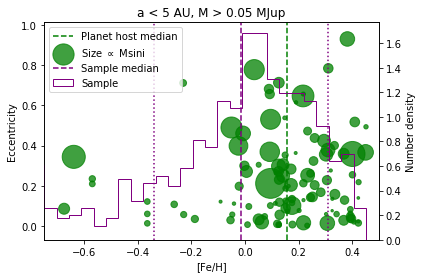

In [260]:
fig, ax = plt.subplots()
plt.title('a < 5 AU, M > 0.05 MJup')
ln1 = ax.scatter(good_spec_filter.fe, good_spec_filter.e, s=list(50*good_spec_filter.mass), 
                alpha=0.75, c='g', label=r'Size $\propto$ Msini')

#Accurately calculate median for planet hosts, don't duplicate metallicity for each planet.
unique_fe = np.unique(good_spec_filter.fe)
median_fe = np.median(unique_fe)
mad_fe = astrostats.mad_std(unique_fe)

ln2 = ax.axvline(x=median_fe, c='green', ls='--', label='Planet host median')
ax.set_xlabel('[Fe/H]')
ax.set_ylabel('Eccentricity')
ax.set_xlim([-0.75, 0.5])

ax2 = ax.twinx()
ln3 = ax2.hist(specmatch.fe, bins=50, histtype='step', color='purple', density=True, label='Sample')
median_sample_fe = np.median(specmatch.fe)
#mad_sample_fe = astrostats.median_absolute_deviation(specmatch.fe)
mad_sample_fe = astrostats.mad_std(specmatch.fe)
ln4 = ax2.axvline(x=median_sample_fe, c='purple', ls='--', label='Sample median')
ax.axvline(x=median_sample_fe+mad_sample_fe, c='purple', ls=':')
ax.axvline(x=median_sample_fe-mad_sample_fe, c='purple', ls=':')
ax2.set_ylabel('Number density')
#ax2.set_xlim([-0.75, 0.5])

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=2)

fig.savefig('planet_candidates/fe_eccentricity_hist.pdf')

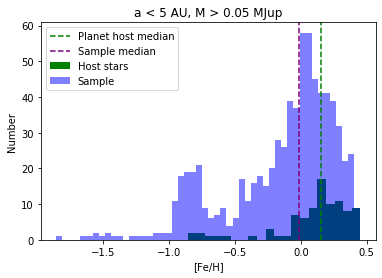

In [261]:
fig, ax = plt.subplots()
plt.title('a < 5 AU, M > 0.05 MJup')

# Accurately calculate median for planet hosts, don't duplicate metallicity for each planet.
unique_fe = np.unique(good_spec_filter.fe)
median_fe = np.median(unique_fe)
mad_fe = astrostats.mad_std(unique_fe)

ln1 = ax.hist(unique_fe, bins=20, histtype='stepfilled', color='green', 
              alpha=1, density=False, label='Host stars')
ln2 = ax.axvline(x=median_fe, c='green', ls='--', label='Planet host median')
ax.set_xlabel('[Fe/H]')
ax.set_ylabel('Number')

ln3 = ax.hist(specmatch.fe, bins=50, histtype='stepfilled', color='blue', 
               alpha=0.5, density=False, label='Sample')
median_sample_fe = np.median(specmatch.fe)
mad_sample_fe = astrostats.mad_std(specmatch.fe)
ln4 = ax.axvline(x=median_sample_fe, c='purple', ls='--', label='Sample median')

lines, labels = ax.get_legend_handles_labels()
ax.legend()

fig.savefig('planet_candidates/fe_two_hist_num.pdf')

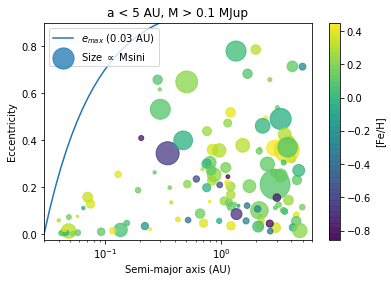

In [54]:
# Overplot peri-distance limit 0.03 AU.
axes = np.logspace(np.log10(0.03), np.log10(6))
e_max = 1 - 0.03/axes

fig, ax = plt.subplots()
plt.title('a < 5 AU, M > 0.1 MJup')
im = ax.scatter(good_spec_filter.axis, good_spec_filter.e, s=list(50*good_spec_filter.mass), 
                c=good_spec_filter.fe, alpha=0.75, label=r'Size $\propto$ Msini')
ax.plot(axes, e_max, label=r'$e_{max}$ (0.03 AU)')
ax.set_xlabel('Semi-major axis (AU)')
ax.set_ylabel('Eccentricity')
ax.set_xlim([0.03,6])
ax.set_ylim([-0.025,0.9])
ax.set_xscale('log')
ax.legend(loc=2)
cbar = fig.colorbar(im)
cbar.ax.set_ylabel('[Fe/H]')#, rotation=270)
fig.savefig('planet_candidates/axis_eccentricity_log_lim.pdf')

# Explore the population's eccentricity distribution.

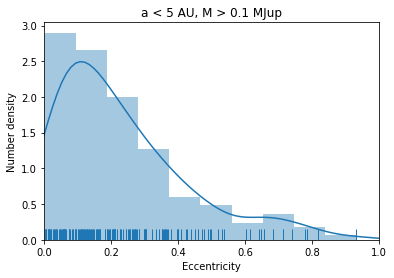

In [60]:
ax = sns.distplot(masses_planet.e, bins=10, rug=True)
ax.set(xlabel='Eccentricity', ylabel='Number density')
ax.set_title('a < 5 AU, M > 0.1 MJup')
ax.set_xlim([0,1])
fig = ax.get_figure()
fig.savefig('planet_candidates/eccentricity_histogram_05.pdf')

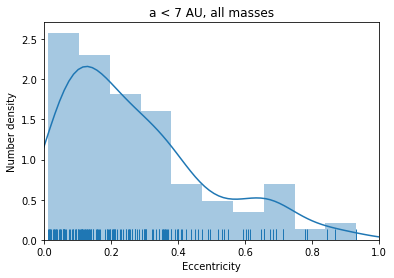

In [61]:
good_spec_all_mass = m_good_spec.query('axis < 7 and axis > 0.1')

ax = sns.distplot(good_spec_all_mass.e, bins=10, rug=True)
#ax.barplot()
ax.set(xlabel='Eccentricity', ylabel='Number density')
ax.set_title('a < 7 AU, all masses')
ax.set_xlim([0,1])
fig = ax.get_figure()
fig.savefig('planet_candidates/eccentricity_histogram_all_masses.pdf')

## Fit Beta distribution to eccentricities. Define a likelihood function for the Beta distribution.

In [65]:
def beta(x, a, b):
    return spec.gamma(a+b)/(spec.gamma(a)*spec.gamma(b)) * x**(a-1) * (1-x)**(b-1)

def lnbetalike(theta, x, y, yerr):
    a, b = theta
    return -0.5*np.sum((y-beta(x, a, b))**2*yerr**-2 + np.log(2*np.pi*yerr**2))

nll = lambda *args: -lnbetalike(*args)
# Kipping: a=0.867, b=3.03
def fit_beta(x, y, yerr, a_init=0.867, b_init=3.03): # Kipping estimates
    fit = op.minimize(nll, [a_init, b_init], args=(x, y, yerr),
                      method='Powell', options={'xtol': 1e-8, 'disp': True})
    return fit.x

In [66]:
e_pdf = np.histogram(masses_planet.e, range=[0.001,1], density=True)
e_num = np.histogram(masses_planet.e, range=[0.001,1], density=False)
print(e_pdf[0])

[2.86803658 2.53062051 1.91202438 1.06848421 0.67483214 0.16870803
 0.39365208 0.28118006 0.05623601 0.05623601]


In [67]:
#yerr = np.sqrt(e_num[0])/np.sum(e_num[0]) #Poisson uncertainty
yerr = 0.1*np.ones(10)
fit = fit_beta(e_pdf[1][:-1], e_pdf[0], yerr, a_init=0.5, b_init=2.3)
print(fit)

[1.05406998 3.76549977]


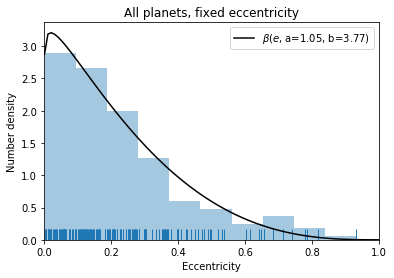

In [68]:
ax = sns.distplot(masses_planet.e, bins=10, rug=True, norm_hist=True, kde=False)
ax.set(xlabel='Eccentricity', ylabel='Number density')
ax.set_title('All planets, fixed eccentricity')
ax.set_xlim([0,1])

# Overplot Beta fit.
es = np.linspace(0.001, 1, num=100)
betas_fit = beta(es, fit[0], fit[1])
ax.plot(es, betas_fit, label=r'$\beta(e$, a=1.05, b=3.77)', c='black')
ax.legend()
fig = ax.get_figure()
fig.savefig('planet_candidates/eccentricity_histogram_beta_fit_719.pdf')

## Explore Beta distribution posterior. NOT redrawing e's from posterior.

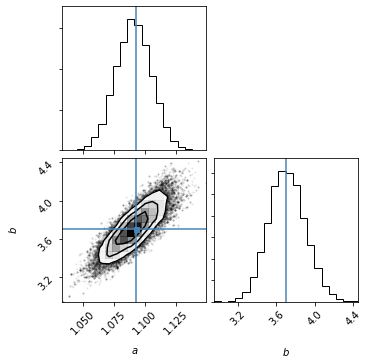

In [136]:
ndim, nwalkers = 2, 100
pos = [fit + 1e-1*np.random.randn(ndim) for i in range(nwalkers)] #1e-1

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnbetalike, args=(e_pdf[1][:-1], e_pdf[0], yerr,))
sampler.run_mcmc(pos, 500)

samples = sampler.chain[:, 100:, :].reshape((-1, ndim))
fig = corner.corner(samples, labels=["$a$", "$b$"],
                      truths=[fit[0], fit[1]])
fig.savefig("beta.pdf")

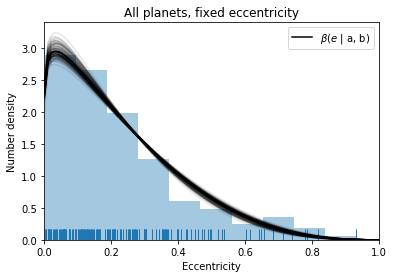

In [138]:
ax = sns.distplot(masses_planet.e, bins=10, rug=True, norm_hist=True, kde=False)#, label=r'$\beta$')
ax.set(xlabel='Eccentricity', ylabel='Number density')
ax.set_title('All planets, fixed eccentricity')
ax.set_xlim([0,1])

# Overplot Beta fit distribution, draw from samples.
es = np.linspace(0.001, 1, num=100)
ax.plot(es, betas_fit, label=r'$\beta(e$ | a, b)', color='black')
for a, b in samples[np.random.randint(len(samples), size=100)]:
    betas = beta(es, a, b)
    ax.plot(es, betas, c='black', alpha=0.1)
ax.legend()
fig = ax.get_figure()
fig.savefig('planet_candidates/eccentricity_histogram_beta_post_719.pdf')

## Repeat for half-Gaussian distribution.

In [124]:
def gauss(x, sig): # Defined for x >= 0 .
    return 2*np.exp(-(x/sig)**2)/np.sqrt(2*np.pi*sig**2)

def lngausslike(sig, x, y, yerr):
    return -0.5*np.sum((y-gauss(x, sig))**2*yerr**-2 + np.log(2*np.pi*yerr**2))

ngll = lambda *args: -lngausslike(*args)
def fit_gauss(x, y, yerr, sig_init=0.2): # Who knows?
    fit = op.minimize(ngll, [sig_init], args=(x, y, yerr),
                      method='Powell', options={'xtol': 1e-8, 'disp': True})
    return fit.x

In [126]:
#ygerr = np.sqrt(e_num[0])/np.sum(e_num[0]) #Poisson uncertainty
ygerr = 0.1*np.ones(10)
fitg = fit_gauss(e_pdf[1][:-1], e_pdf[0], yerr, sig_init=0.33)
print(fitg)

Optimization terminated successfully.
         Current function value: 13.878099
         Iterations: 2
         Function evaluations: 107
0.33407355268577765


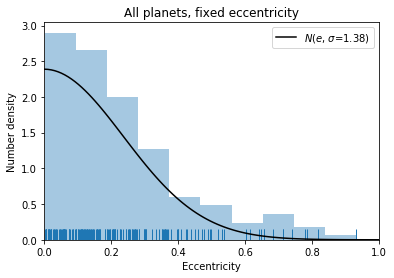

In [127]:
ax = sns.distplot(masses_planet.e, bins=10, rug=True, norm_hist=True, kde=False)
ax.set(xlabel='Eccentricity', ylabel='Number density')
ax.set_title('All planets, fixed eccentricity')
ax.set_xlim([0,1])

# Overplot Beta fit.
es = np.linspace(0.001, 1, num=100)
gausses_fit = gauss(es, fitg)
ax.plot(es, gausses_fit, label=r'$N(e$, $\sigma$=1.38)', c='black')
ax.legend()
fig = ax.get_figure()
fig.savefig('planet_candidates/eccentricity_histogram_gauss_fit_719.pdf')

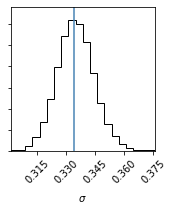

In [128]:
ndim, nwalkers = 1, 100
pos = [fitg + 5*1e-2*np.random.randn(ndim) for i in range(nwalkers)] 

samplerg = emcee.EnsembleSampler(nwalkers, ndim, lngausslike, args=(e_pdf[1][:-1], e_pdf[0], yerr))
samplerg.run_mcmc(pos, 500)

samplesg = samplerg.chain[:, 100:, :].reshape((-1, ndim))
fig = corner.corner(samplesg, labels=[r'$\sigma$'],
                      truths=[fitg])
fig.savefig("gauss.pdf")

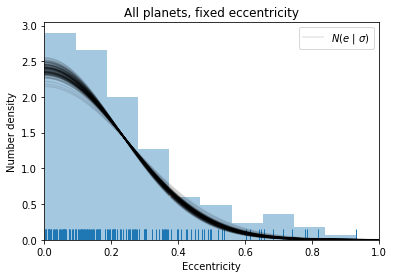

In [130]:
ax = sns.distplot(masses_planet.e, bins=10, rug=True, norm_hist=True, kde=False)#, label=r'$\beta$')
ax.set(xlabel='Eccentricity', ylabel='Number density')
ax.set_title('All planets, fixed eccentricity')
ax.set_xlim([0,1])

# Overplot Gaussian fit distribution, draw from samples.
es = np.linspace(0.001, 1, num=100)
ax.plot(es, gausses_fit, label=r'$N(e\ |\ \sigma$)', alpha=0.1, c='black')
for sig in samplesg[np.random.randint(len(samplesg), size=100)]:
    gausses = gauss(es, sig)
    ax.plot(es, gausses, c='black', alpha=0.1)
ax.legend()
fig = ax.get_figure()
fig.savefig('planet_candidates/eccentricity_histogram_gauss_post_719.pdf')

## Test hierarchical inference. Use Legacy catalog eccentricities & median uncertainties, but simulate bound Gaussian posteriors.

In [411]:
masses_planet.columns

Index(['Unnamed: 0', 'hostname', 'status', 'mass', 'mass_med', 'mass_minus',
       'mass_plus', 'axis', 'axis_med', 'axis_minus', 'axis_plus', 'per',
       'per_med', 'per_minus', 'per_plus', 'k', 'k_med', 'k_minus', 'k_plus',
       'e', 'e_med', 'e_minus', 'e_plus'],
      dtype='object')

In [27]:
def bound(array):
    return np.random.choice(array[(array > 0) & (array < 1)], 100)

# Generate a population, synthetic posteriors, based on real MAP values and CIs. 
masses_noncirc = masses_planet.query('axis > 0.1')
e_minus = np.array(masses_noncirc.e_minus)
e_plus = np.array(masses_noncirc.e_plus)

posts = []
for i, e in enumerate(masses_noncirc.e):
    sig_e = 0.5*(e_plus[i] - e_minus[i])
    posts.append(bound(sig_e*np.random.randn(1000) + e))
posts = np.array(posts)

In [206]:
posts.shape

(151, 100)

In [237]:
# Define the population likelihood for the beta distribution. Can generalize later.
def popprob(samples, a, b):
    K = len(samples)    # Number of planets
    N = len(samples[0]) # Number of posterior samples
    
    sums = []
    for sample in samples:
        probs = beta(sample, a, b)
        sums.append(np.sum(probs)/N)
    return np.prod(sums) # *exp(−integral(Γ(e|θ)de)) (BUT THAT'S 1!)


def lnpoplike(theta, samples):
    a, b = theta
    return np.log(popprob(samples, a, b))

def lnpopprior(theta):
    a, b = theta
    #if 0 < a < 2 and 1 < b < 15:
    if 0 < a < 10 and 0 < b < 50:
        return 0.0
    return -np.inf

def lnpopprob(theta, samples):
    lp = lnpopprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnpoplike(theta, samples)

In [238]:
print(fit[0], fit[1])
print(popprob(posts, fit[0], fit[1]))
print(lnpopprob([fit[0], fit[1]], posts))

1.0540699840787053 3.7654997696590797
[1.11075144 1.11213125 1.13516032 1.12357567 1.12861621 1.10141306
 1.11619094 1.12997769 1.13631657 1.12312961 1.11602066 1.12861621
 1.13536382 1.10492542 1.1285732  1.11689733 1.13803582 1.14014195
 1.101299   1.12837658 1.14322775 1.14838265 1.12393461 1.12915965
 1.12522185 1.11716011 1.12835902 1.15379254 1.13253586 1.1432386
 1.11560529 1.13536382 1.12201115 1.1394984  1.11675694 1.13681194
 1.12293546 1.11126143 1.11641722 1.1129957  1.11741015 1.14607906
 1.11163686 1.109583   1.11476423 1.12495709 1.1333697  1.10141306
 1.11898257 1.07552054 1.11962    1.13464744 1.13662458 1.1215146
 1.12035616 1.15171998 1.12290533 1.12187827 1.12320714 1.13051254
 1.11403428 1.11944224 1.09287754 1.10124469 1.12314034 1.07794559
 1.13855796 1.11927106 1.09408825 1.12778116 1.11639119 1.12190515
 1.10539369 1.11033797 1.11406379 1.11716053 1.13224007 1.1135484
 1.1410866  1.13802901 1.09069884 1.11160358 1.12982709 1.13631657
 1.12856714 1.13789636 1.15

[2.90663502 1.9967396  3.17571626 2.37213275 3.03758137 2.54887508
 2.9263867  3.12343736 2.03307818 2.03307818 2.2446881  1.61209309
 2.7589431  2.80711615 2.80931665 2.09536177 3.17089337 2.37213275
 2.1210515  2.52162064 3.07376427 2.32435837 3.15458239 2.44179644
 2.57188295 2.54887508 2.76913987 2.31654484 3.09197656 2.66433176
 2.11215453 2.1459953  2.80548961 3.16498767 2.34034133 2.50207012
 1.85373578 2.49914212 2.3020093  2.46635371 2.90663502 2.80931665
 1.98538078 2.08106505 2.64077971 3.00152568 2.68030649 2.43719237
 2.48983272 2.55139791 2.65538435 2.99902232 2.52548755 2.94221871
 2.19102522 1.94205455 3.18082991 2.81444767 3.08825717 3.0710298
 1.7627917  1.98383617 2.63667826 1.86169217 3.00981224 2.39108938
 2.03788676 3.20891687 2.48274394 2.49008604 2.64077971 1.73473699
 2.00086129 2.69856051 1.87671694 2.45060458 2.80700725 2.52162064
 2.59812629 3.06442094 2.69805664 1.76467086 3.17571626 3.11424265
 2.80102666 2.68753667 2.32740318 1.97999134 2.81444767 2.95538

In [38]:
e_pdf = np.histogram(masses_noncirc.e, range=[0.001,1], density=True)
e_num = np.histogram(masses_noncirc.e, range=[0.001,1], density=False)

#yerr = np.sqrt(e_num[0])/np.sum(e_num[0]) # Poisson uncertainty
yerr = 0.1*np.ones(10)
fit_noncirc = fit_beta(e_pdf[1][:-1], e_pdf[0], yerr, a_init=0.5, b_init=2.3)
print(fit_noncirc)

[1.09233944 3.70026307]


## Try sampling!

In [188]:
ndim, nwalkers = 2, 100
pos = [fit + 1e-2*np.random.randn(ndim) for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnpopprob, args=(posts,))
sampler.run_mcmc(pos, 1000)

(array([[1.15401043, 3.28541056],
        [1.27114459, 3.45738825],
        [0.82249519, 2.48897592],
        [0.83557037, 2.89682025],
        [0.91993995, 2.79383681],
        [0.89026728, 2.84798944],
        [0.95324024, 2.57851107],
        [1.05850081, 3.78168574],
        [1.09623135, 3.4531199 ],
        [0.78187352, 2.36440658],
        [1.01327479, 3.37186457],
        [1.00802546, 3.01833356],
        [1.1099652 , 3.37084064],
        [1.19117486, 3.21088899],
        [0.93701226, 2.94886827],
        [0.87496288, 2.66909973],
        [0.90301381, 2.44318771],
        [0.83956984, 2.38378298],
        [0.88469172, 2.63783076],
        [1.17982141, 3.00995034],
        [1.03110614, 2.99317744],
        [0.97100758, 2.88986269],
        [1.11903268, 3.18599966],
        [0.92558873, 2.32704521],
        [0.97212158, 2.66618001],
        [1.16042849, 2.87124315],
        [1.15387443, 3.29153844],
        [1.07440885, 2.95107037],
        [1.13893347, 3.8598507 ],
        [1.213

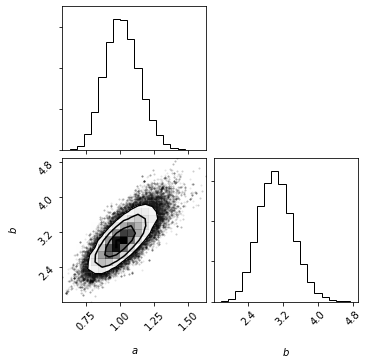

In [189]:
samples = sampler.chain[:, 20:, :].reshape((-1, ndim))
# Draw the median of the posterior. Or mode, stats.mode(samples_single)
a_all_median = np.median(samples[:, 0])
b_all_median = np.median(samples[:, 1])

fig = corner.corner(samples, labels=["$a$", "$b$"])#, truths=[fit_noncirc[0], fit_noncirc[1]])
fig.savefig("analysis_plots/corner_pop_K.pdf")

In [40]:
np.percentile(samples, [16, 50, 84], axis=0)

array([[0.88514987, 2.63480096],
       [1.00114476, 3.00934956],
       [1.12895945, 3.422142  ]])

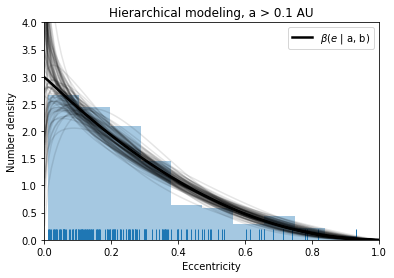

In [122]:
ax = sns.distplot(masses_noncirc.e, bins=10, rug=True, norm_hist=True, kde=False)#, label=r'$\beta$')
ax.set(xlabel='Eccentricity', ylabel='Number density')
ax.set_title('Hierarchical modeling, a > 0.1 AU')
ax.set_xlim([0,1])
ax.set_ylim([0, 4])

# Overplot Beta fit distribution, draw from samples.
es = np.linspace(0.001, 1, num=100)
beta_all_median = beta(es, a_all_median, b_all_median)

ax.plot(es, beta_all_median, label=r'$\beta(e$ | a, b)', color='black', linewidth=2.5)
for a, b in samples[np.random.randint(len(samples), size=100)]:
    betas = beta(es, a, b)
    ax.plot(es, betas, c='black', alpha=0.1)
ax.legend()
fig = ax.get_figure()
fig.savefig('analysis_plots/eccentricity_pop_beta_whole_719.pdf')#analysis_plots/

## Separate the (observed) singles and multis. Need to add nplanets to the dataframe first.

In [71]:
names = np.unique(masses_noncirc.hostname)
nplanets = np.array(masses_noncirc.groupby('hostname').count()['status'])
db_nplanets = pd.DataFrame({'hostname':names, 'nplanets':nplanets})

masses_noncirc = pd.merge(masses_noncirc, db_nplanets, on='hostname').reset_index()

## Now generate synthetic posteriors, TO BE REPLACED WITH REAL SAMPLES.

In [76]:
masses_single = masses_noncirc.query('nplanets == 1').reset_index()
masses_multi  = masses_noncirc.query('nplanets != 1').reset_index()

posts_single = []
for i, e in enumerate(masses_single.e):
    sig_e = 0.5*(masses_single.e_plus[i] - masses_single.e_minus[i])
    posts_single.append(bound(sig_e*np.random.randn(1000) + e))
posts_single = np.array(posts_single)

posts_multi  = []
for i, e in enumerate(masses_multi.e):
    sig_e = 0.5*(masses_multi.e_plus[i] - masses_multi.e_minus[i])
    posts_multi.append(bound(sig_e*np.random.randn(1000) + e))
posts_multi = np.array(posts_multi)

In [77]:
ndim, nwalkers = 2, 100
pos = [fit + 1e-2*np.random.randn(ndim) for i in range(nwalkers)]

sampler_single = emcee.EnsembleSampler(nwalkers, ndim, lnpopprob, args=(posts_single,))
sampler_single.run_mcmc(pos, 1000)

(array([[1.08618718, 2.36710806],
        [1.21110943, 2.6229293 ],
        [0.8095876 , 2.22333403],
        [0.97284268, 2.32851036],
        [1.18895249, 2.53512688],
        [1.11942296, 2.36888134],
        [0.84378662, 2.12289434],
        [0.91403091, 2.50072065],
        [1.29795159, 3.47900463],
        [1.00550138, 1.89042887],
        [0.95306337, 2.2873013 ],
        [0.95123844, 2.19707114],
        [0.95745319, 2.08454979],
        [1.02819443, 2.1639134 ],
        [1.00417552, 2.54651348],
        [1.19209075, 2.81377185],
        [0.96535927, 2.56391999],
        [0.91836314, 2.32109763],
        [0.87760821, 1.97646014],
        [0.75346772, 1.72963307],
        [0.99164791, 2.13156546],
        [1.16998856, 2.14763378],
        [1.0110757 , 1.90264096],
        [1.05024602, 2.31355141],
        [0.84549318, 3.04547508],
        [1.06350011, 2.17998314],
        [1.11157089, 2.69730951],
        [1.00882738, 2.58692527],
        [0.88319827, 2.41234726],
        [1.007

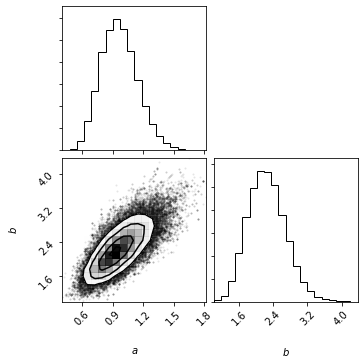

In [83]:
samples_single = sampler_single.chain[:, 50:, :].reshape((-1, ndim))
# Draw the median of the posterior. Or mode, stats.mode(samples_single)
a_single_median = np.median(samples_single[:, 0])
b_single_median = np.median(samples_single[:, 1])

fig = corner.corner(samples_single, labels=["$a$", "$b$"])#, truths=[fit_noncirc[0], fit_noncirc[1]])
fig.savefig("analysis_plots/corner_pop_single.pdf")

In [139]:
np.percentile(samples_single, [16, 50, 84], axis=0)

array([[0.7858685 , 1.81115163],
       [0.95424564, 2.22402813],
       [1.14456904, 2.67841393]])

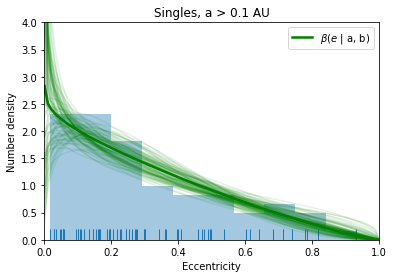

In [120]:
ax = sns.distplot(masses_single.e, bins=10, rug=True, norm_hist=True, kde=False)#, label=r'$\beta$')
ax.set(xlabel='Eccentricity', ylabel='Number density')
ax.set_title('Singles, a > 0.1 AU')
ax.set_xlim([0,1])
ax.set_ylim([0, 4])

# Overplot Beta fit distribution, draw from samples.
es = np.linspace(0.001, 1, num=100)
beta_single_median = beta(es, a_single_median, b_single_median)

ax.plot(es, beta_single_median, label=r'$\beta(e$ | a, b)', color='g', linewidth=2.5)
for a, b in samples_single[np.random.randint(len(samples_single), size=100)]:
    betas = beta(es, a, b)
    ax.plot(es, betas, c='g', alpha=0.1)
ax.legend()
fig = ax.get_figure()
fig.savefig('analysis_plots/eccentricity_pop_beta_singles_719.pdf')

In [82]:
ndim, nwalkers = 2, 100
pos = [fit + 1e-2*np.random.randn(ndim) for i in range(nwalkers)]

sampler_multi = emcee.EnsembleSampler(nwalkers, ndim, lnpopprob, args=(posts_multi,))
sampler_multi.run_mcmc(pos, 1000)

(array([[1.07825139, 4.2785678 ],
        [1.23699876, 4.44459204],
        [0.6540701 , 2.55369427],
        [1.05011174, 4.83808296],
        [0.99900618, 4.36523354],
        [0.97310513, 4.54770017],
        [1.31909376, 6.11443247],
        [1.62063896, 6.33225059],
        [1.30397038, 4.88241158],
        [1.62698363, 7.85129147],
        [1.78708983, 7.79054939],
        [0.94576258, 3.60589716],
        [1.28027897, 4.81285554],
        [1.12119613, 4.86976106],
        [1.11234924, 4.880202  ],
        [1.0659167 , 4.97879506],
        [1.50219172, 5.53269056],
        [1.53186768, 6.69287729],
        [1.68636756, 7.19535379],
        [1.55301901, 5.0718731 ],
        [1.4523751 , 5.71320361],
        [1.12953276, 4.18427616],
        [1.52376036, 6.62217685],
        [1.1217592 , 4.79396719],
        [1.23921994, 4.54131297],
        [1.22742984, 4.32787896],
        [1.47644504, 6.46216983],
        [1.42548207, 5.63654766],
        [1.54224441, 5.80062595],
        [1.030

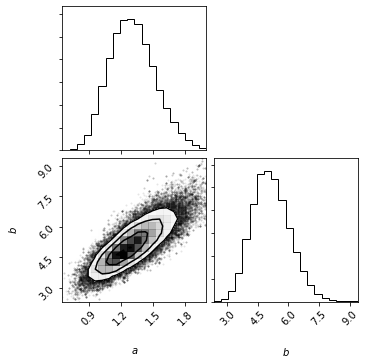

In [101]:
samples_multi = sampler_multi.chain[:, 50:, :].reshape((-1, ndim))
# Draw the median of the posterior. Or mode, stats.mode(samples_single)
a_multi_median = np.median(samples_multi[:, 0])
b_multi_median = np.median(samples_multi[:, 1])

fig = corner.corner(samples_multi, labels=["$a$", "$b$"])
fig.savefig("analysis_plots/corner_pop_multi.pdf")

In [140]:
np.percentile(samples_multi, [16, 50, 84], axis=0)

array([[1.09490751, 4.23680643],
       [1.29840246, 5.08099053],
       [1.52341694, 6.0584008 ]])

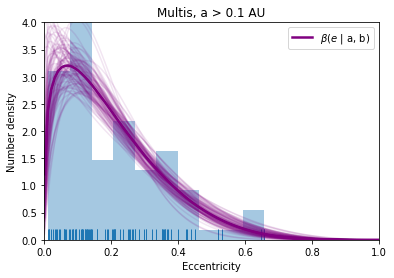

In [112]:
ax = sns.distplot(masses_multi.e, bins=10, rug=True, norm_hist=True, kde=False)#, label=r'$\beta$')
ax.set(xlabel='Eccentricity', ylabel='Number density')
ax.set_title('Multis, a > 0.1 AU')
ax.set_xlim([0,1])
ax.set_ylim([0, 4])

# Overplot Beta fit distribution, draw from samples.
es = np.linspace(0.001, 1, num=100)
beta_multi_median = beta(es, a_multi_median, b_multi_median)
ax.plot(es, beta_multi_median, label=r'$\beta(e$ | a, b)', color='purple', linewidth=2.5)

for a, b in samples_multi[np.random.randint(len(samples_multi), size=100)]:
    betas = beta(es, a, b)
    ax.plot(es, betas, c='purple', alpha=0.1)
ax.legend()
fig = ax.get_figure()
fig.savefig('analysis_plots/eccentricity_pop_beta_multis_719.pdf')

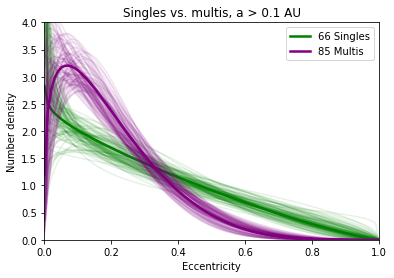

In [114]:
fig, ax = plt.subplots()
ax.set_xlim([0, 1])
ax.set_ylim([0, 4])
ax.set(xlabel='Eccentricity', ylabel='Number density')
ax.set_title('Singles vs. multis, a > 0.1 AU')

nsingles = len(masses_single)
nmultis  = len(masses_multi)

# Overplot Beta fit distribution, single median and many drawn from samples.
es = np.linspace(0.001, 1, num=100)

beta_single_median = beta(es, a_single_median, b_single_median)
ax.plot(es, beta_single_median, label='{} Singles'.format(nsingles), color='green', linewidth=2.5)
for a, b in samples_single[np.random.randint(len(samples_single), size=100)]:
    betas = beta(es, a, b)
    ax.plot(es, betas, c='g', alpha=0.1)

beta_multi_median = beta(es, a_multi_median, b_multi_median)
ax.plot(es, beta_multi_median, label='{} Multis'.format(nmultis), color='purple', linewidth=2.5)
for a, b in samples_multi[np.random.randint(len(samples_multi), size=100)]:
    betas = beta(es, a, b)
    ax.plot(es, betas, c='purple', alpha=0.1)

ax.legend()
fig.savefig('analysis_plots/eccentricity_pop_comparison_beta_719.pdf')

## Separate planets by mass, boundary at Msini = 0.1 Mjup (see mass histograms below). Leave in the planets within 0.1 AU for now.

In [118]:
planets_big   = masses_planet.query('mass >= 0.1 and axis > 0.1')
planets_small = masses_planet.query('mass < 0.1 and axis > 0.1')

### Add number of planets again, WITHIN each sample. Number of planets with Msini less than 0.1 MJup, and number of planets with Msini greater than 0.1 MJup.

In [119]:
names_big = np.unique(planets_big.hostname)
nplanets_big = np.array(planets_big.groupby('hostname').count()['status'])
db_nplanets_big = pd.DataFrame({'hostname':names_big, 'nplanets':nplanets_big})

names_small = np.unique(planets_small.hostname)
nplanets_small = np.array(planets_small.groupby('hostname').count()['status'])
db_nplanets_small = pd.DataFrame({'hostname':names_small, 'nplanets':nplanets_small})

planets_big   = pd.merge(planets_big, db_nplanets_big, on='hostname').reset_index()
planets_small = pd.merge(planets_small, db_nplanets_small, on='hostname').reset_index()

### Draw posteriors, again. Synthetic for now, TO BE REPLACED WITH REAL SAMPLES.

In [120]:
posts_big = []
for i, e in enumerate(planets_big.e):
    sig_e = 0.5*(planets_big.e_plus[i] - planets_big.e_minus[i])
    posts_big.append(bound(sig_e*np.random.randn(1000) + e))
posts_big = np.array(posts_big)

posts_small = []
for i, e in enumerate(planets_small.e):
    sig_e = 0.5*(planets_small.e_plus[i] - planets_small.e_minus[i])
    posts_small.append(bound(sig_e*np.random.randn(1000) + e))
posts_small = np.array(posts_small)

### Sample and plot.

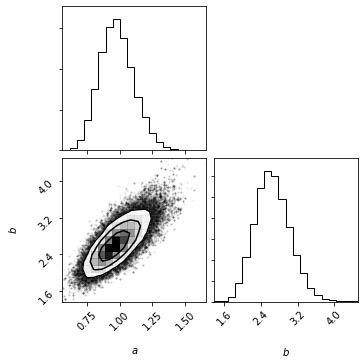

In [84]:
ndim, nwalkers = 2, 100
pos = [fit + 1e-2*np.random.randn(ndim) for i in range(nwalkers)]
sampler_big = emcee.EnsembleSampler(nwalkers, ndim, lnpopprob, args=(posts_big,))
sampler_big.run_mcmc(pos, 1000)

samples_big = sampler_big.chain[:, 50:, :].reshape((-1, ndim))
# Draw the median of the posterior. Or mode, stats.mode(samples_single)
a_big_median = np.median(samples_big[:, 0])
b_big_median = np.median(samples_big[:, 1])

fig = corner.corner(samples_big, labels=["$a$", "$b$"])
fig.savefig("analysis_plots/corner_pop_big.pdf")

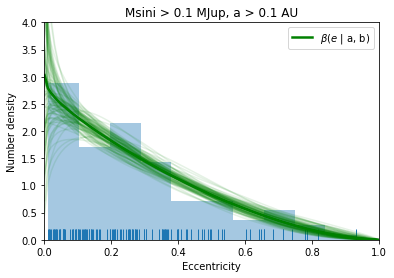

In [96]:
ax = sns.distplot(planets_big.e, bins=10, rug=True, norm_hist=True, kde=False)
ax.set(xlabel='Eccentricity', ylabel='Number density')
ax.set_title('Msini > 0.1 MJup, a > 0.1 AU')
ax.set_xlim([0, 1])
ax.set_ylim([0, 4])

# Overplot Beta fit distribution, draw from samples.
es = np.linspace(0.001, 1, num=100)
beta_big_median = beta(es, a_big_median, b_big_median)
ax.plot(es, beta_big_median, label=r'$\beta(e$ | a, b)', color='green', linewidth=2.5)

for a, b in samples_big[np.random.randint(len(samples_big), size=100)]:
    betas = beta(es, a, b)
    ax.plot(es, betas, c='green', alpha=0.1)
ax.legend()
fig = ax.get_figure()
fig.savefig('analysis_plots/eccentricity_synth_beta_big.pdf')

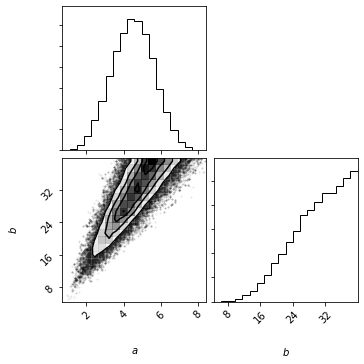

In [116]:
ndim, nwalkers = 2, 100
pos = [fit + 1e-2*np.random.randn(ndim) for i in range(nwalkers)]
sampler_small = emcee.EnsembleSampler(nwalkers, ndim, lnpopprob, args=(posts_small,))
sampler_small.run_mcmc(pos, 1000)

samples_small = sampler_small.chain[:, 50:, :].reshape((-1, ndim))
# Draw the median of the posterior. Or mode, stats.mode(samples_single)
a_small_median = np.median(samples_small[:, 0])
b_small_median = np.median(samples_small[:, 1])

fig = corner.corner(samples_small, labels=["$a$", "$b$"])
fig.savefig("analysis_plots/corner_pop_small.pdf")

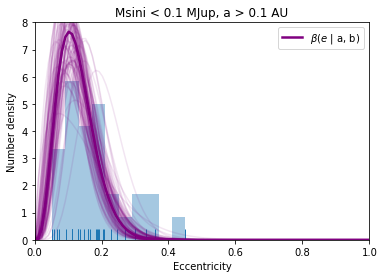

In [162]:
ax = sns.distplot(planets_small.e, bins=10, rug=True, norm_hist=True, kde=False)
ax.set(xlabel='Eccentricity', ylabel='Number density')
ax.set_title('Msini < 0.1 MJup, a > 0.1 AU')
ax.set_xlim([0, 1])
ax.set_ylim([0, 8])

# Overplot Beta fit distribution, draw from samples.
es = np.linspace(0.001, 1, num=100)
beta_small_median = beta(es, a_small_median, b_small_median)
ax.plot(es, beta_small_median, label=r'$\beta(e$ | a, b)', color='purple', linewidth=2.5)

for a, b in samples_small[np.random.randint(len(samples_small), size=100)]:
    betas = beta(es, a, b)
    ax.plot(es, betas, c='purple', alpha=0.1)
ax.legend()
fig = ax.get_figure()
fig.savefig('analysis_plots/eccentricity_synth_beta_small.pdf')

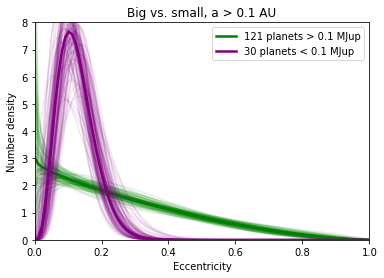

In [163]:
fig, ax = plt.subplots()
ax.set_xlim([0, 1])
ax.set_ylim([0, 8])
ax.set(xlabel='Eccentricity', ylabel='Number density')
#ax.set_title('Boundary at 0.1 MJup')
ax.set_title('Big vs. small, a > 0.1 AU')

nbig    = len(planets_big)
nsmall  = len(planets_small)

# Overplot Beta fit distribution, single median and many drawn from samples.
es = np.linspace(0.001, 1, num=100)

beta_big_median = beta(es, a_big_median, b_big_median)
ax.plot(es, beta_big_median, label='{} planets > 0.1 MJup'.format(nbig), color='green', linewidth=2.5)
for a, b in samples_big[np.random.randint(len(samples_big), size=100)]:
    betas = beta(es, a, b)
    ax.plot(es, betas, c='g', alpha=0.1)

beta_small_median = beta(es, a_small_median, b_small_median)
ax.plot(es, beta_small_median, label='{} planets < 0.1 MJup'.format(nsmall), color='purple', linewidth=2.5)
for a, b in samples_small[np.random.randint(len(samples_small), size=100)]:
    betas = beta(es, a, b)
    ax.plot(es, betas, c='purple', alpha=0.1)

ax.legend()
fig.savefig('analysis_plots/eccentricity_synth_comparison_beta_big_small.pdf')

### Split giant planets into single-giant, multi-giant.

In [122]:
planets_big_single = planets_big.query('nplanets == 1').reset_index()
planets_big_multi  = planets_big.query('nplanets != 1').reset_index()

posts_big_single = []
for i, e in enumerate(planets_big_single.e):
    sig_e = 0.5*(planets_big_single.e_plus[i] - planets_big_single.e_minus[i])
    posts_big_single.append(bound(sig_e*np.random.randn(1000) + e))
posts_big_single = np.array(posts_big_single)

posts_big_multi  = []
for i, e in enumerate(planets_big_multi.e):
    sig_e = 0.5*(planets_big_multi.e_plus[i] - planets_big_multi.e_minus[i])
    posts_big_multi.append(bound(sig_e*np.random.randn(1000) + e))
posts_big_multi = np.array(posts_big_multi)

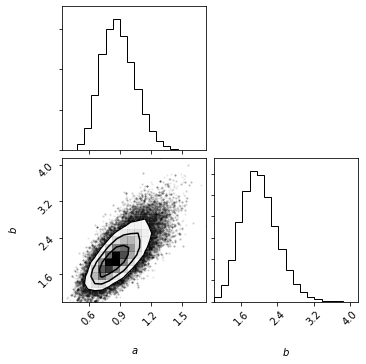

In [125]:
ndim, nwalkers = 2, 100
pos = [fit + 1e-2*np.random.randn(ndim) for i in range(nwalkers)]
sampler_big_single = emcee.EnsembleSampler(nwalkers, ndim, lnpopprob, 
                                           args=(posts_big_single,))
sampler_big_single.run_mcmc(pos, 1000)

samples_big_single = sampler_big_single.chain[:, 50:, :].reshape((-1, ndim))
# Draw the median of the posterior. Or mode, stats.mode(samples_single)
a_big_single_median = np.median(samples_big_single[:, 0])
b_big_single_median = np.median(samples_big_single[:, 1])

fig = corner.corner(samples_big_single, labels=["$a$", "$b$"])
fig.savefig("analysis_plots/corner_pop_big_single.pdf")

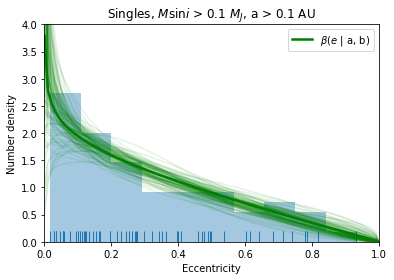

In [165]:
ax = sns.distplot(planets_big_single.e, bins=10, rug=True, norm_hist=True, kde=False)
ax.set(xlabel='Eccentricity', ylabel='Number density')
ax.set_title(r'Singles, $M$sin$i$ > 0.1 $M_J$, a > 0.1 AU')
ax.set_xlim([0, 1])
ax.set_ylim([0, 4])

# Overplot Beta fit distribution, draw from samples.
es = np.linspace(0.001, 1, num=100)
beta_big_single_median = beta(es, a_big_single_median, b_big_single_median)
ax.plot(es, beta_big_single_median, label=r'$\beta(e$ | a, b)', color='green', linewidth=2.5)

for a, b in samples_big_single[np.random.randint(len(samples_big_single), size=100)]:
    betas = beta(es, a, b)
    ax.plot(es, betas, c='green', alpha=0.1)
ax.legend()
fig = ax.get_figure()
fig.savefig('analysis_plots/eccentricity_synth_beta_big_single.pdf')

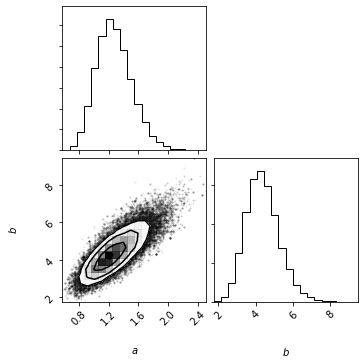

In [126]:
ndim, nwalkers = 2, 100
pos = [fit + 1e-2*np.random.randn(ndim) for i in range(nwalkers)]
sampler_big_multi = emcee.EnsembleSampler(nwalkers, ndim, lnpopprob, 
                                           args=(posts_big_multi,))
sampler_big_multi.run_mcmc(pos, 1000)

samples_big_multi = sampler_big_multi.chain[:, 50:, :].reshape((-1, ndim))
# Draw the median of the posterior. Or mode, stats.mode(samples_multi)
a_big_multi_median = np.median(samples_big_multi[:, 0])
b_big_multi_median = np.median(samples_big_multi[:, 1])

fig = corner.corner(samples_big_multi, labels=["$a$", "$b$"])
fig.savefig("analysis_plots/corner_pop_big_multi.pdf")

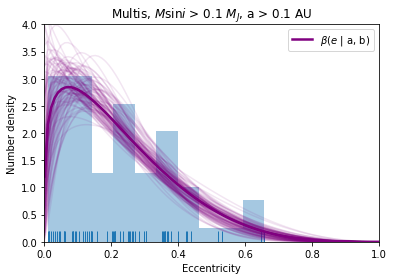

In [164]:
ax = sns.distplot(planets_big_multi.e, bins=10, rug=True, norm_hist=True, kde=False)
ax.set(xlabel='Eccentricity', ylabel='Number density')
ax.set_title(r'Multis, $M$sin$i$ > 0.1 $M_J$, a > 0.1 AU')
ax.set_xlim([0, 1])
ax.set_ylim([0, 4])

# Overplot Beta fit distribution, draw from samples.
es = np.linspace(0.001, 1, num=100)
beta_big_multi_median = beta(es, a_big_multi_median, b_big_multi_median)
ax.plot(es, beta_big_multi_median, label=r'$\beta(e$ | a, b)', color='purple', linewidth=2.5)

for a, b in samples_big_multi[np.random.randint(len(samples_big_multi), size=100)]:
    betas = beta(es, a, b)
    ax.plot(es, betas, c='purple', alpha=0.1)
ax.legend()
fig = ax.get_figure()
fig.savefig('analysis_plots/eccentricity_synth_beta_big_multi.pdf')

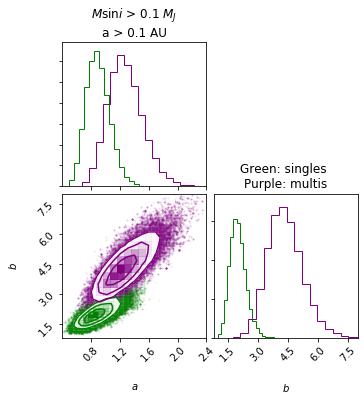

In [234]:
## Plot the two distributions on top of each other.
fig = corner.corner(samples_big_single, labels=["$a$", "$b$"], color='green')#, quantiles=[0.16, 0.5, 0.84])
corner.corner(samples_big_multi, fig=fig, color='purple')#, quantiles=[0.16, 0.5, 0.84])
# Histogram limits.
fig.axes[0].set_xlim([0.4, 2.4])
fig.axes[3].set_xlim([0.8, 8])
#fig.axes[3].set_ylim([0, 20000])
# Scatterplot limits.
fig.axes[2].set_xlim([0.4, 2.4])
fig.axes[2].set_ylim([0.8, 8])
# Plots to clarify.
fig.axes[0].set_title(r'$M$sin$i$ > 0.1 $M_J$' + ' \na > 0.1 AU')
fig.axes[3].set_title('Green: singles \nPurple: multis')
fig.savefig("analysis_plots/corner_pop_big_comparison.pdf")

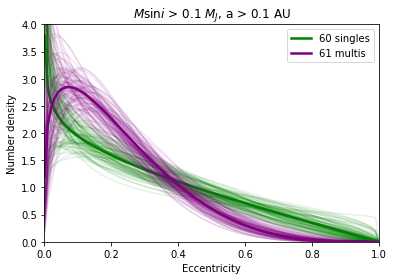

In [240]:
fig, ax = plt.subplots()
ax.set_xlim([0, 1])
ax.set_ylim([0, 4])
ax.set(xlabel='Eccentricity', ylabel='Number density')
#ax.set_title('Boundary at 0.1 MJup')
ax.set_title(r'$M$sin$i$ > 0.1 $M_J$, a > 0.1 AU')

nsingle = len(planets_big_single)
nmulti  = len(planets_big_multi)

# Overplot Beta fit distribution, single median and many drawn from samples.
es = np.linspace(0.001, 1, num=100)

beta_big_single_median = beta(es, a_big_single_median, b_big_single_median)
ax.plot(es, beta_big_single_median, label='{} singles'.format(nsingle), color='green', linewidth=2.5)
for a, b in samples_big_single[np.random.randint(len(samples_big_single), size=100)]:
    betas = beta(es, a, b)
    ax.plot(es, betas, c='g', alpha=0.1)

beta_big_multi_median = beta(es, a_big_multi_median, b_big_multi_median)
ax.plot(es, beta_big_multi_median, label='{} multis'.format(nmulti), color='purple', linewidth=2.5)
for a, b in samples_big_multi[np.random.randint(len(samples_big_multi), size=100)]:
    betas = beta(es, a, b)
    ax.plot(es, betas, c='purple', alpha=0.1)

ax.legend()
fig.savefig('analysis_plots/eccentricity_synth_comparison_beta_big.pdf')

## Make observational stats histograms.

In [242]:
obs_stats = pd.read_csv('legacy_tables/observation_stats.csv')
obs_stats = obs_stats.query('baseline > 2922 and Nobs > 17')
obs_stats.columns

Index(['Unnamed: 0', 'Nobs', 'Nobs_CORAVEL', 'Nobs_apf', 'Nobs_j', 'Nobs_k',
       'Nobs_lick', 'Nobs_mcdonald', 'baseline', 'baseline_CORAVEL',
       'baseline_apf', 'baseline_j', 'baseline_k', 'baseline_lick',
       'baseline_mcdonald', 'med_err_CORAVEL', 'med_err_apf', 'med_err_j',
       'med_err_k', 'med_err_lick', 'med_err_mcdonald', 'name'],
      dtype='object')

In [243]:
obs_stats.name

1         145675
2           1461
3         146233
4         149661
5         149724
6         150437
7         151288
8         152391
9          15335
10        153458
11        153557
12        154088
13        154363
14        155712
16         18143
17         69830
19         10002
20        100180
21         10008
22        100623
23        101259
24         10145
25        101501
26        102195
27        103095
28        103932
29        104067
30        104304
31        104556
32         10476
         ...    
697     hip16404
698        gl273
699      g161-29
700     hip51007
701       92222a
702    bd-103166
703     hip54532
704     hip57087
706     hip57548
708     hip60559
709       g60-06
710        gl486
711      111484b
714      120476a
723     hip91699
724     hip92403
725     g207-019
730         5470
732       144287
733        18445
734        29461
735        30649
736        31412
737        37124
738        65430
739        68988
740        80606
741       1200

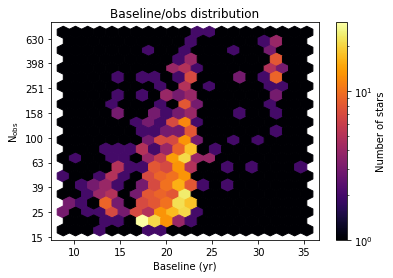

In [45]:
fig, ax = plt.subplots()
hb = ax.hexbin(obs_stats.baseline/365.25, np.log10(obs_stats.Nobs), 
               gridsize=20, bins='log', cmap='inferno')
ax.set_title("Baseline/obs distribution")
ax.set_xlabel('Baseline (yr)')
ax.set_ylabel(r'N$_\mathrm{obs}$')
#ax.set_ylabel(r'log$_{10}$(N$_\mathrm{obs}$)')

# Manually set Nobs logarithmic tick marks.
def format_fn(tick_val, tick_pos):
    return str(int(10**tick_val))

#ax.locator_params(axis='y', nbins=1)
ax.yaxis.set_major_formatter(FuncFormatter(format_fn))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

cb = fig.colorbar(hb, ax=ax)
cb.set_label('Number of stars')
fig.savefig('legacy_tables/hist_base_nobs_2D.pdf')

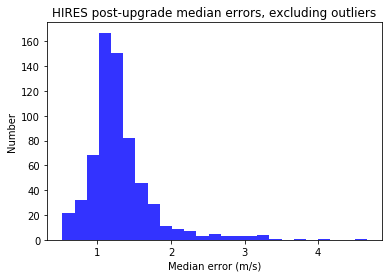

In [162]:
fig, ax = plt.subplots()
ax.hist(obs_stats.query('med_err_j < 5').med_err_j, bins=25, histtype='stepfilled', color='blue', 
              alpha=0.8, density=False, label='Host stars')
ax.set(xlabel='Median error (m/s)', ylabel='Number')
ax.set_title('HIRES post-upgrade median errors, excluding outliers')
fig.savefig('legacy_tables/hist_HIRES_post_err.pdf')

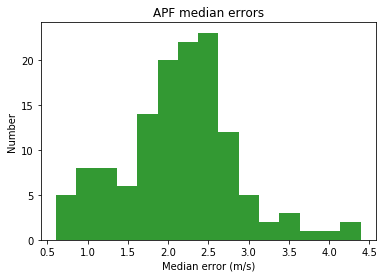

In [168]:
fig, ax = plt.subplots() #.query('med_err_j < 5')
ax.hist(obs_stats.med_err_apf, bins=15, histtype='stepfilled', color='green', 
              alpha=0.8, density=False, label='Host stars')
ax.set(xlabel='Median error (m/s)', ylabel='Number')
ax.set_title('APF median errors')
fig.savefig('legacy_tables/hist_APF_err.pdf')

Text(0.5, 1.0, 'Total baseline distribution')

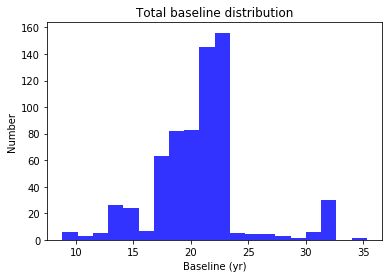

In [178]:
fig, ax = plt.subplots()
ax.hist(obs_stats.baseline/365.25, bins=20, histtype='stepfilled', color='blue', 
              alpha=0.8, density=False, label='Host stars')
ax.set(xlabel='Baseline (yr)', ylabel='Number')
ax.set_title('Total baseline distribution')

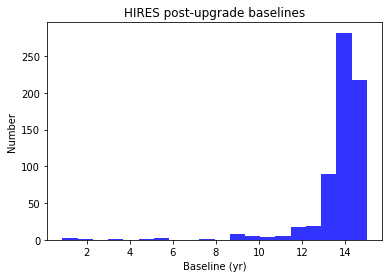

In [179]:
fig, ax = plt.subplots()
ax.hist(obs_stats.baseline_j/365.25, bins=20, histtype='stepfilled', color='blue', 
              alpha=0.8, density=False, label='Host stars')
ax.set(xlabel='Baseline (yr)', ylabel='Number')
ax.set_title('HIRES post-upgrade baselines')
fig.savefig('legacy_tables/hist_HIRES_post_base.pdf')

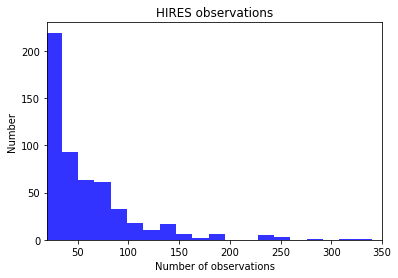

In [180]:
fig, ax = plt.subplots()
ax.hist(obs_stats.Nobs_j + obs_stats.Nobs_k, bins=20, histtype='stepfilled', color='blue', 
              alpha=0.8, density=False, label='Host stars')
ax.set(xlabel='Number of observations', ylabel='Number')
ax.set_xlim([20,350])
ax.set_title('HIRES observations')
fig.savefig('legacy_tables/hist_HIRES_nobs.pdf')

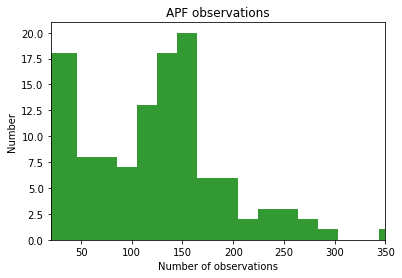

In [143]:
fig, ax = plt.subplots()
ax.hist(obs_stats.Nobs_apf, bins=20, histtype='stepfilled', color='green', 
              alpha=0.8, density=False, label='Host stars')
ax.set(xlabel='Number of observations', ylabel='Number')
ax.set_xlim([20,350])
ax.set_title('APF observations')
fig.savefig('legacy_tables/hist_APF_nobs.pdf')

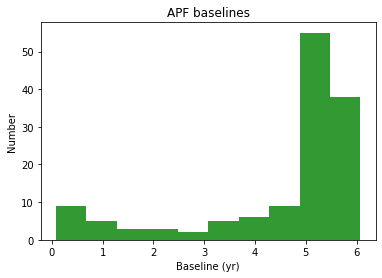

In [145]:
fig, ax = plt.subplots()
ax.hist(obs_stats.baseline_apf/365.25, bins=10, histtype='stepfilled', color='green', 
              alpha=0.8, density=False, label='Host stars')
ax.set(xlabel='Baseline (yr)', ylabel='Number')
ax.set_title('APF baselines')
fig.savefig('legacy_tables/hist_APF_base.pdf')

## Examine mass and period distributions.

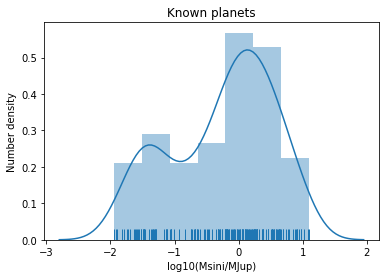

In [18]:
axold = sns.distplot(np.log10(masses_planet.query('mass < 15')['mass']), rug=True)
axold.set(xlabel='log10(Msini/MJup)', ylabel='Number density')
axold.set_title('Known planets')
fig = axold.get_figure()
fig.savefig('planet_candidates/mass_histogram_all_log.pdf')

In [17]:
masses_close = masses_planet.query('axis < 1 and mass < 15')
masses_mid   = masses_planet.query('axis > 1 and axis < 3 and mass < 15')
masses_far   = masses_planet.query('axis > 3 and mass < 15')

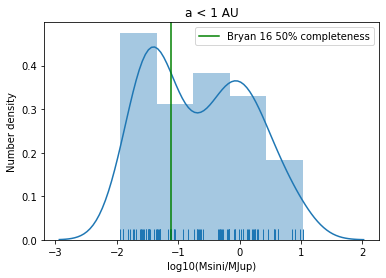

In [22]:
mclose = masses_close.mass
thresh_close = np.log10(0.075) #50% completeness threshold

axclose = sns.distplot(np.log10(mclose), kde=True, rug=True)
axclose.axvline(thresh_close, c='g', label='Bryan 16 50% completeness')
axclose.set(xlabel='log10(Msini/MJup)', ylabel='Number density')
axclose.set_title('a < 1 AU')
axclose.legend()

figclose = axclose.get_figure()
figclose.savefig('planet_candidates/close_histogram.pdf')

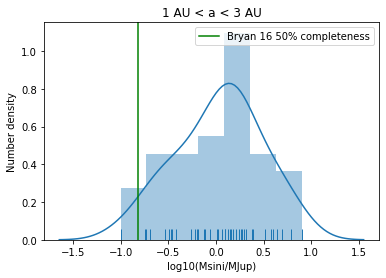

In [20]:
mmid = masses_mid.mass
thresh_mid = np.log10(0.15) #50% completeness threshold

axmid = sns.distplot(np.log10(mmid), rug=True)
axmid.axvline(thresh_mid, c='g', label='Bryan 16 50% completeness')
axmid.set(xlabel='log10(Msini/MJup)', ylabel='Number density')
axmid.set_title('1 AU < a < 3 AU')
axmid.legend()

figmid = axmid.get_figure()
figmid.savefig('planet_candidates/middle_histogram.pdf')

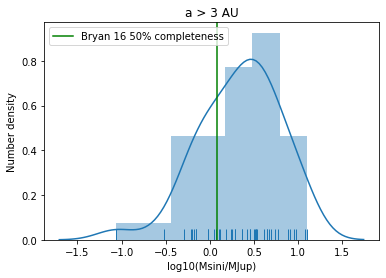

In [21]:
mfar = masses_far.mass
thresh_far = np.log10(1.2) #50% completeness threshold

axfar = sns.distplot(np.log10(mfar), rug=True)
axfar.axvline(thresh_far, c='g', label='Bryan 16 50% completeness')
axfar.set(xlabel='log10(Msini/MJup)', ylabel='Number density')
axfar.set_title('a > 3 AU')
axfar.legend()

figfar = axfar.get_figure()
figfar.savefig('planet_candidates/far_histogram.pdf')

## Make distributions of periods and period ratios.

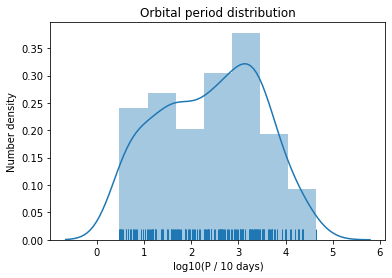

In [137]:
# Only use ratios below 20.
axper = sns.distplot(np.log10(masses_planet.per), rug=True)
axper.set(xlabel='log10(P / 10 days)', ylabel='Number density')
axper.set_title('Orbital period distribution')

figper = axper.get_figure()
figper.savefig('planet_candidates/period_histogram.pdf')

In [133]:
def period_ratios(pers):
    ratios = []
    nplanets = len(pers)
    sorted = np.sort(pers)
    for i in np.arange(nplanets):
        for j in np.arange(i):
            ratios.append(sorted[i]/sorted[j])
    return ratios

In [134]:
systems = masses_planet.hostname.unique()

In [135]:
all_ratios = []
for system in systems:
    sys_db = masses_planet.query('hostname == "{}"'.format(system))#    .loc[masses_planet.hostname == system]
    if len(sys_db) > 1:
        sys_ratios = period_ratios(sys_db.per)
        all_ratios.append(sys_ratios)
all_ratios = np.concatenate(all_ratios)

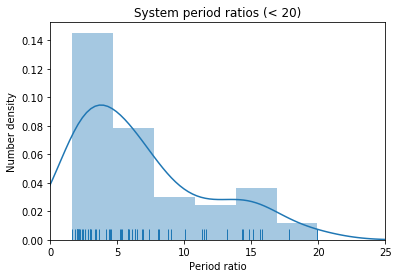

In [136]:
# Only use ratios below 20.
filtered_ratios = np.extract(all_ratios < 20, all_ratios)
axper = sns.distplot(filtered_ratios, rug=True)
axper.set_xlim([0,25])
axper.set(xlabel='Period ratio', ylabel='Number density')
axper.set_title('System period ratios (< 20)')

figper = axper.get_figure()
figper.savefig('planet_candidates/period_ratio_histogram.pdf')

## Catalogue trend systems.

In [ ]:
trends = masses_only.loc[masses_only.per > 5*10**3]
len(trends)